In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from tqdm import tqdm
from scipy.stats import pearsonr
from collections import defaultdict
import gseapy as gp
import anndata
from scipy import stats
from eval_utils import *
from plot_utils import *
sns.set_style('whitegrid')

In [13]:
outdir = '../results'
figdir = f'{outdir}/overleaf/figures'
dataset = 'Adamson2016'
seeds = [1, 2, 3]
methods = ['cpa', 'gears', 'scgpt', 'scgpt_ft', 'nonctl-mean', 'matching-mean']

In [14]:
results_df = pd.DataFrame(
    columns=["method", "pert", "seed", "corr_all", "corr_20de", "mse_all", "mse_20de", "jaccard", "one gene", "train"]
)
for seed in seeds:
    file = f'../data/{dataset.lower()}/{dataset.lower()}_{seed}.h5ad'
    adata = anndata.read_h5ad(file)

    # Get control mean, non control mean (pert_mean), and non control mean differential
    train_adata = adata[adata.obs['split'] == 'train']
    control_adata = train_adata[train_adata.obs['control'] == 1]
    pert_adata = train_adata[train_adata.obs['control'] == 0]
    control_mean = np.array(control_adata.X.mean(axis=0))[0]
    pert_mean = np.array(pert_adata.X.mean(axis=0))[0]
    for method in tqdm(methods):
        post_gt_df = pd.read_csv(f'{outdir}/{dataset}_{seed}_{method}_post-gt.csv', index_col=[0, 1])
        post_pred_df = pd.read_csv(f'{outdir}/{dataset}_{seed}_{method}_post-pred.csv', index_col=[0, 1])
        conditions = post_gt_df.index.get_level_values('condition').unique()
        for condition in conditions:
            gene_list = condition.split("+")
            one_gene = False
            if "ctrl" in gene_list:
                gene_list.remove("ctrl")
                one_gene = True
            one_gene_str = "1-gene" if one_gene else "2-gene"

            # Get data
            X_true = post_gt_df.loc[condition].values[0]
            X_pred = post_pred_df.loc[condition].values[0]
            delta_true = X_true - control_mean
            delta_pred = X_pred - control_mean
            n_train = post_gt_df.loc[condition].index.get_level_values('n_train').values[0]

            # Get top 20 DE genes
            adata_condition = adata[adata.obs["condition"] == condition]

            # Select top 20 DE genes
            top20_de_genes = adata.uns["top_non_dropout_de_20"][
                adata_condition.obs["condition_name"].values[0]
            ]
            top20_de_idxs = np.argwhere(
                np.isin(adata.var.index, top20_de_genes)
            ).ravel()

            # Jaccard similarity
            top20_de_idxs_pred = get_topk_de_gene_ids(control_mean, X_pred, k=20)
            
            # Store results
            results_df.loc[len(results_df)] = [
                    method,
                    condition,
                    seed,
                    pearsonr(delta_true, delta_pred)[0],
                    pearsonr(delta_true[top20_de_idxs], delta_pred[top20_de_idxs])[0],
                    np.mean((delta_true - delta_pred)**2),
                    np.mean((delta_true[top20_de_idxs] - delta_pred[top20_de_idxs])**2),
                    jaccard_similarity(top20_de_idxs, top20_de_idxs_pred),
                    one_gene_str,
                    n_train,
                ]

100%|███████████████████████████████████████████████| 6/6 [00:01<00:00,  3.27it/s]


In [27]:
# Calculate RMSE
results_df['rmse_all'] = np.sqrt(results_df['mse_all'])
results_df['rmse_20de'] = np.sqrt(results_df['mse_20de'])

#### Combined figure

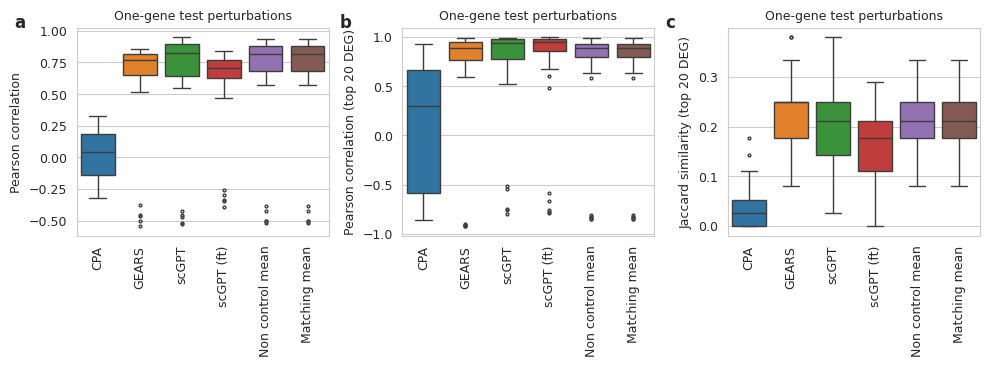

In [15]:
nrows = 2
ncols = 3
fontsize = 9
fliersize = 2
labels=['CPA', 'GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean', 'Matching mean']
fig = plt.figure(figsize=(10, 6))
plt.subplot(nrows, ncols, 1)
letter_annotation(plt.gca(), -.25, 1, 'a')
sns.boxplot(data=results_df, x='method', y='corr_all', hue='method',
            fliersize=fliersize,
            order=methods)
plt.xticks(np.arange(len(labels)), labels, rotation=90, fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson correlation', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('');

plt.subplot(nrows, ncols, 2)
letter_annotation(plt.gca(), -.25, 1, 'b')
sns.boxplot(data=results_df, y='corr_20de', x='method', hue='method',
            order=methods,
            fliersize=fliersize)
plt.xticks(np.arange(len(labels)), labels, rotation=90, fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson correlation (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('');

plt.subplot(nrows, ncols, 3)
letter_annotation(plt.gca(), -.25, 1, 'c')
sns.boxplot(data=results_df, y='jaccard', x='method', hue='method',
            order=methods,
            fliersize=fliersize)
plt.xticks(np.arange(len(labels)), labels, rotation=90, fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One-gene test perturbations', fontsize=fontsize)
plt.ylabel('Jaccard similarity (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('');
# legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# handles, labels = plt.gca().get_legend_handles_labels()
# legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.07), fancybox=True, shadow=True, ncol=5)

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.savefig(f'{figdir}/{dataset}_pearsondiff_combined.pdf', bbox_inches='tight');

#### Combined MSE figure

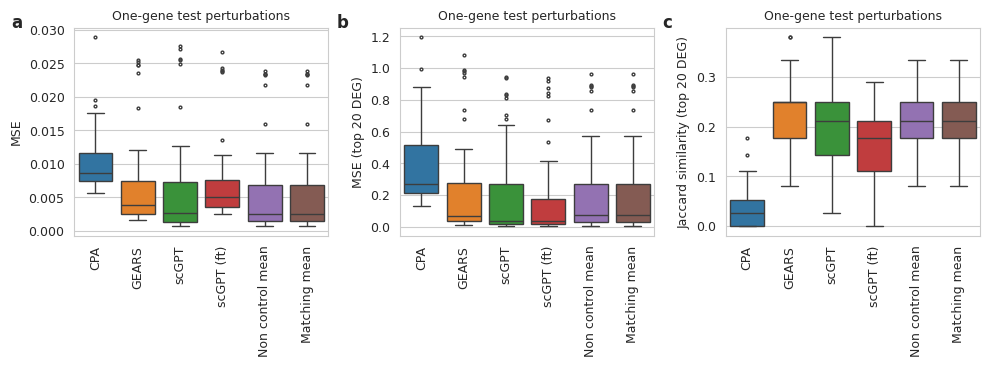

In [16]:
nrows = 2
ncols = 3
fontsize = 9
fliersize = 2
labels=['CPA', 'GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean', 'Matching mean']
fig = plt.figure(figsize=(10, 6))
plt.subplot(nrows, ncols, 1)
letter_annotation(plt.gca(), -.25, 1, 'a')
sns.boxplot(data=results_df, x='method', y='mse_all', hue='method',
            fliersize=fliersize,
            order=methods)
plt.xticks(np.arange(len(labels)), labels, rotation=90, fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One-gene test perturbations', fontsize=fontsize)
plt.ylabel('MSE', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('');

plt.subplot(nrows, ncols, 2)
letter_annotation(plt.gca(), -.25, 1, 'b')
sns.boxplot(data=results_df, y='mse_20de', x='method', hue='method',
            order=methods,
            fliersize=fliersize)
plt.xticks(np.arange(len(labels)), labels, rotation=90, fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One-gene test perturbations', fontsize=fontsize)
plt.ylabel('MSE (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('');

plt.subplot(nrows, ncols, 3)
letter_annotation(plt.gca(), -.25, 1, 'c')
sns.boxplot(data=results_df, y='jaccard', x='method', hue='method',
            order=methods,
            fliersize=fliersize)
plt.xticks(np.arange(len(labels)), labels, rotation=90, fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One-gene test perturbations', fontsize=fontsize)
plt.ylabel('Jaccard similarity (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('');
# legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# handles, labels = plt.gca().get_legend_handles_labels()
# legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.07), fancybox=True, shadow=True, ncol=5)

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.savefig(f'{figdir}/{dataset}_msediff_combined.pdf', bbox_inches='tight');

#### Cumulative performance sorting perturbations by alignment with average treatment effect¶

In [6]:
df, df_pair, df_norm, pert_names = compute_shift_similarities(adata)

In [7]:
df_ = df[df['variable'] == 'avg_ctl'].sort_values(by='value', ascending=False).set_index('pert_names')
df_norm_ = df_norm[df_norm['variable'] == 'avg_ctl'].sort_values(by='value', ascending=False).set_index('pert_names')
df_['value'].mean()

0.7622133

In [19]:
def plot_performance(results_df_, df_, metric, xlabel='Number of 1-gene test perturbations', ylabel='Pearson correlation (top 20 DEGs)'):
    # Calculate scores
    unique_test_perts = results_df_['pert'].unique()
    sorted_test_perts_df = df_.loc[unique_test_perts].sort_values(by='value', ascending=False)
    discard_perts = []
    scores_df = pd.DataFrame()
    mean_cossims = []
    for i, p in tqdm(enumerate(sorted_test_perts_df[sorted_test_perts_df['value'] > 0].index)): 
        res_df = results_df_[~results_df_['pert'].isin(discard_perts)]
        score = res_df[[metric, 'method']].groupby('method').mean()
        scores_df[i] = score
        mean_cossim = sorted_test_perts_df[~sorted_test_perts_df.index.isin(discard_perts)]['value'].mean()
        mean_cossims.append(mean_cossim)
        discard_perts.append(p)
        
    # Plot
    scores_df_ = scores_df[scores_df.index != 'matching-mean']
    # plt.imshow(np.array(mean_cossims).reshape(1, -1))
    ax = plt.gca()
    sns.lineplot(data=scores_df_.T, ax=ax)
    n = len(mean_cossims) # len(results_df_[results_df_['method'] == 'nonctl-mean'])
    idxs = np.arange(n // 10 + 1)
    ax.set_xticks(idxs*10, len(sorted_test_perts_df)-10*idxs) # .set_xticks(idxs, n-idxs)

    # Create a gradient background using imshow
    # Generate a gradient array
    gradient = np.array(mean_cossims).reshape(1, -1)  # Horizontal gradient
    gradient = np.vstack([gradient]*256)  # Stack it to fill the background

    # Display the gradient image behind the plot
    img = ax.imshow(gradient, extent=[0, len(mean_cossims)+1, ax.get_ylim()[0], ax.get_ylim()[1]],
                    aspect='auto', cmap='coolwarm', alpha=0.2, zorder=0)
    # cbar = plt.colorbar(img, ax=ax, orientation='horizontal', fraction=0.05, pad=0.15)
    # cbar.set_label('Gradient Intensity')
    secax = ax.secondary_xaxis("top")
    idxs = np.arange(n // 10 + 1)
    # secax.set_ticks(idxs*10, [f'{s:.2f}' for s in np.array(mean_cossims)[10*idxs]])
    secax.set_xlabel('Average cosine similarity')

    # plt.grid(axis='x', visible=False)
    plt.grid(False)
    idxs = []
    poss = [0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
    for pos in poss:
        idx = (np.abs(np.array(mean_cossims) - pos)).argmin()  # find_nearest(mean_cossims, pos)
        idxs.append(idx)
        ax.axvline(x=idx, color='grey', linestyle='--', linewidth=0.4, alpha=0.5, zorder=1)
    secax.set_xticks(idxs, poss) # .set_xticks(idxs, n-idxs)

    # Legend
    handles, labels = plt.gca().get_legend_handles_labels()
    legend = plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=6)
    labels=['CPA', 'GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean']
    for i, label in enumerate(labels):
        legend.get_texts()[i].set_text(label)
    plt.tight_layout()

    plt.ylabel(ylabel)
    plt.xlabel(xlabel);
    
    return scores_df_

46it [00:00, 707.13it/s]


,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
method,,,,,,,,,,,,,,,,,,,,,
cpa,0.023591,0.025434,0.023209,0.019144,0.021139,0.019331,0.015122,0.015405,0.024008,0.030446,...,0.050137,0.035726,0.053933,0.035509,0.041230,0.042015,0.037753,0.057749,0.018893,0.070495
gears,0.649049,0.645843,0.643008,0.639566,0.636933,0.633435,0.631209,0.627592,0.620410,0.615978,...,0.261024,0.237438,0.214396,0.188847,0.126140,0.073293,0.014403,-0.071726,-0.166804,-0.289535
nonctl-mean,0.703510,0.699737,0.696121,0.692575,0.689082,0.685246,0.681485,0.677501,0.669740,0.665813,...,0.296318,0.270477,0.242194,0.208568,0.126965,0.073136,0.008385,-0.070387,-0.168367,-0.291477
scgpt,0.689321,0.685391,0.681522,0.678163,0.674249,0.670075,0.665747,0.661065,0.653231,0.648275,...,0.258501,0.228416,0.205778,0.176175,0.101108,0.055613,-0.009669,-0.079021,-0.178831,-0.301998
scgpt_ft,0.621353,0.620484,0.617788,0.614700,0.612552,0.609613,0.607209,0.604902,0.599208,0.596139,...,0.355615,0.338723,0.303569,0.262489,0.188518,0.123940,0.081816,-0.008287,-0.083388,-0.184747


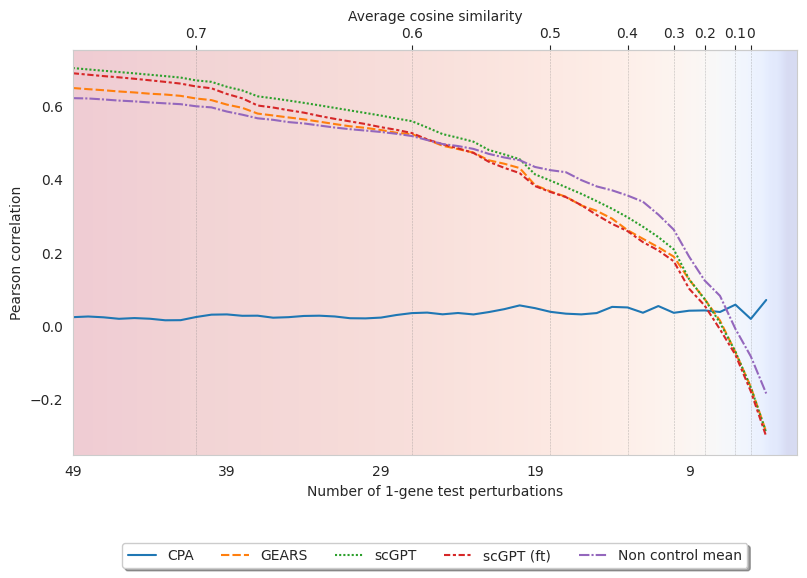

In [22]:
metric = 'corr_all' # 'corr_20de' # 'corr_20de'
results_df_ = results_df[results_df['one gene'] == '1-gene']
plt.figure(figsize=(8, 6))
plot_performance(results_df_, df_, metric, ylabel='Pearson correlation')

46it [00:00, 589.52it/s]


,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
method,,,,,,,,,,,,,,,,,,,,,
cpa,0.114507,0.126284,0.118277,0.104742,0.119713,0.112140,0.099790,0.088371,0.114660,0.131154,...,0.001377,-0.041822,0.009494,-0.032030,-0.009008,-0.007065,-0.041377,0.027470,-0.067801,0.017615
gears,0.723018,0.718761,0.715928,0.711454,0.708529,0.705704,0.702057,0.697180,0.688212,0.684571,...,0.237260,0.207634,0.163823,0.122190,0.034476,-0.045873,-0.132270,-0.267177,-0.404678,-0.609672
nonctl-mean,0.730102,0.725968,0.723044,0.718705,0.715709,0.712660,0.708672,0.703836,0.694708,0.691679,...,0.276275,0.248848,0.203308,0.154065,0.053508,-0.023834,-0.111938,-0.237464,-0.363567,-0.549796
scgpt,0.768228,0.764862,0.761277,0.758048,0.754647,0.750658,0.746495,0.742305,0.734199,0.729580,...,0.317592,0.276097,0.238296,0.200880,0.108764,0.067061,-0.005579,-0.108562,-0.244260,-0.423046
scgpt_ft,0.787367,0.784916,0.781713,0.778296,0.775051,0.771341,0.768301,0.764620,0.757652,0.753320,...,0.375247,0.336906,0.290385,0.237056,0.157741,0.075248,-0.005028,-0.129741,-0.263012,-0.446188


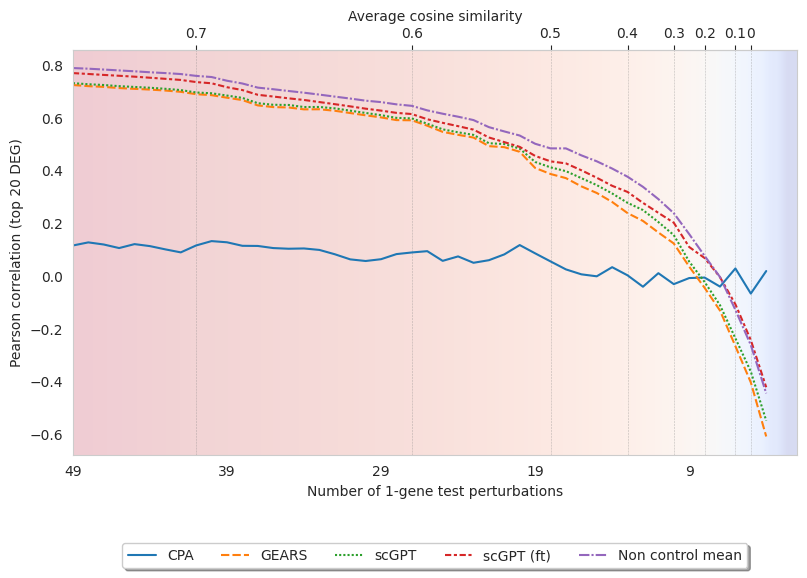

In [24]:
metric = 'corr_20de' # 'corr_20de'
results_df_ = results_df[results_df['one gene'] == '1-gene']
plt.figure(figsize=(8, 6))
plot_performance(results_df_, df_, metric, ylabel='Pearson correlation (top 20 DEG)')

46it [00:00, 676.16it/s]


,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
method,,,,,,,,,,,,,,,,,,,,,
cpa,0.098804,0.099094,0.099353,0.099696,0.099913,0.100232,0.100667,0.100883,0.101422,0.101537,...,0.116309,0.116160,0.112315,0.111609,0.111982,0.109226,0.107589,0.104602,0.100574,0.101558
gears,0.072294,0.072814,0.073229,0.073696,0.074110,0.074624,0.075002,0.075506,0.076582,0.077198,...,0.116916,0.118660,0.117454,0.118237,0.123436,0.125301,0.128528,0.132770,0.136082,0.146097
nonctl-mean,0.064041,0.064656,0.065195,0.065747,0.066267,0.066855,0.067464,0.068060,0.069251,0.069788,...,0.111797,0.113500,0.112579,0.114079,0.120534,0.122226,0.125707,0.129118,0.132178,0.141692
scgpt,0.066198,0.066825,0.067370,0.067882,0.068462,0.069066,0.069742,0.070462,0.071582,0.072292,...,0.117856,0.120235,0.119103,0.120495,0.126919,0.128336,0.132441,0.135441,0.139600,0.149913
scgpt_ft,0.078140,0.078316,0.078694,0.079163,0.079496,0.079932,0.080268,0.080654,0.081508,0.081920,...,0.110993,0.112112,0.113365,0.116844,0.121684,0.126368,0.128632,0.135174,0.137857,0.146607


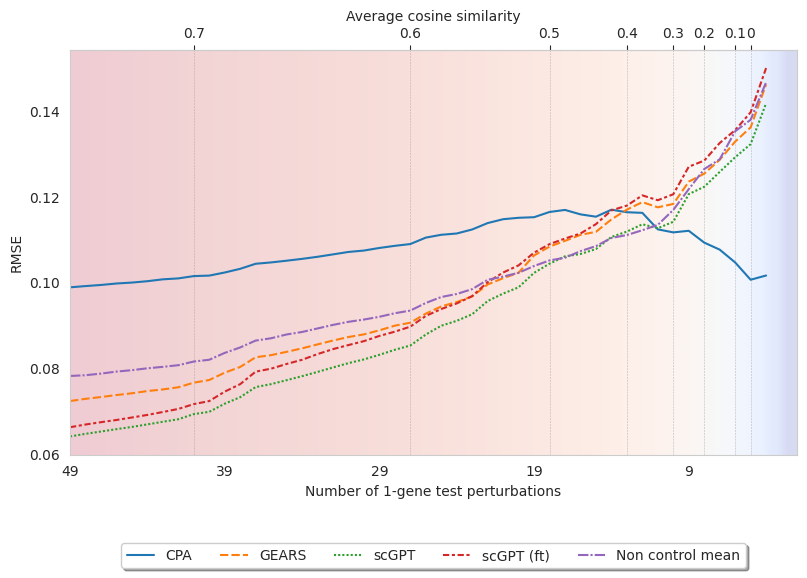

In [30]:
metric = 'rmse_all' # 'corr_20de'
results_df_ = results_df[results_df['one gene'] == '1-gene']
plt.figure(figsize=(8, 6))
plot_performance(results_df_, df_, metric, ylabel='RMSE')

46it [00:00, 527.01it/s]


,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
method,,,,,,,,,,,,,,,,,,,,,
cpa,0.593149,0.595915,0.598751,0.602704,0.604736,0.607565,0.611637,0.615882,0.621224,0.623605,...,0.774173,0.778299,0.755881,0.753692,0.773893,0.757429,0.730973,0.707923,0.696900,0.723129
gears,0.383540,0.387752,0.390970,0.395966,0.398899,0.402119,0.406006,0.411525,0.420390,0.424273,...,0.728617,0.738214,0.731972,0.738530,0.777665,0.785497,0.777627,0.805475,0.823062,0.908975
nonctl-mean,0.378950,0.383984,0.387480,0.392254,0.395801,0.399419,0.403808,0.409309,0.418821,0.422523,...,0.710147,0.719315,0.716567,0.726474,0.769502,0.775419,0.766431,0.784934,0.795965,0.869589
scgpt,0.341767,0.345279,0.348921,0.352324,0.355977,0.359916,0.364961,0.369792,0.378474,0.383562,...,0.688409,0.715370,0.709189,0.715881,0.757060,0.750370,0.740606,0.753670,0.779065,0.857245
scgpt_ft,0.302392,0.304738,0.308097,0.311713,0.314848,0.318855,0.322006,0.325794,0.332504,0.337213,...,0.585001,0.604853,0.617589,0.649198,0.671806,0.708257,0.695814,0.750450,0.772530,0.850443


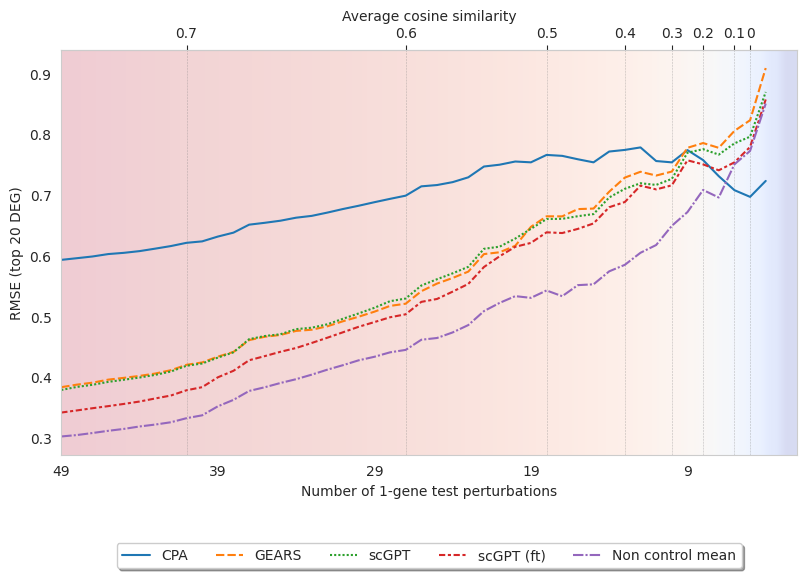

In [28]:
metric = 'rmse_20de' # 'corr_20de'
results_df_ = results_df[results_df['one gene'] == '1-gene']
plt.figure(figsize=(8, 6))
plot_performance(results_df_, df_, metric, ylabel='RMSE (top 20 DEG)')